# Analysis

**Problem Statement:**

There are so many apps on app store, some paid some free; I want to validate few of these scenarios:
 - What makes an app successfull, what is that metric
 - What other metrics are available?
 - Is there correlation between this success metric and other metrics
 - What does the clusters look like if we try to cluster them
 
This might sound vague at the moment but essentially I want to analyse apps in app store;

### Task 1: In this notebook we would essentially be dealing with pre processing of the data to make it more convenient to use;

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.set_palette("Set1", 8, .75)

In [2]:
df = pd.read_csv("../dataset/data.csv")

In [3]:
# list of all columns
df.columns

Index(['kind', 'features', 'advisories', 'trackCensoredName', 'fileSizeBytes',
       'contentAdvisoryRating', 'genreIds', 'currentVersionReleaseDate',
       'currency', 'wrapperType', 'version', 'artistName', 'artistId',
       'genres', 'price', 'description', 'trackName', 'bundleId',
       'isVppDeviceBasedLicensingEnabled', 'primaryGenreName', 'releaseDate',
       'minimumOsVersion', 'formattedPrice', 'primaryGenreId',
       'averageUserRating', 'userRatingCount', 'avgUserRatingCV',
       'userRatingCountCV', 'sellerUrl', 'releaseNotes'],
      dtype='object')

In [4]:
print ("No of rows in dataset: %d, No of columns: %d" %  (df.shape[0], df.shape[1]))

No of rows in dataset: 152047, No of columns: 30


**Note that:** `trackName` property is the name of application and `bundleId` is the unique name; we can use these bost as unique properties;


In [5]:
# let's define a new dataframe where we will store more processed information
data = pd.DataFrame()
data['bundleId'] = df['bundleId']
data['trackName'] = df['trackName']

## Pre processing

### (1) Kind

In [6]:
df.kind.value_counts()

software    152047
Name: kind, dtype: int64

**Summary**: all data in the list is of same kind hence we will ignore this property
### (2) features

In [7]:
df.features.value_counts()

["iosUniversal"]    105740
[]                   46307
Name: features, dtype: int64

**Summary:** since there are only two possible outcomes I'll conver this to a column called `isUniversal`

In [8]:
def getIsUniversal(x):
    if x == '[]':
        return False
    return True

data['IsUniversal'] = df['features'].apply(lambda x: getIsUniversal(x))

data.head(10)

,bundleId,trackName,IsUniversal
0,com.aaa.iphone.discounts,AAA Mobile,True
1,com.nextgenreality.gunclublite,AAA GUN CLUB lite,False
2,com.mcgames.chaosstrike2,Vanguard Online - AAA Shooting Free Online Gam...,True
3,com.BulletParty.BunboGames,AAA Bullet Party - Online first person shooter...,True
4,com.fmapp2010.ISearchFree,iSheacher,False
5,com.onteca.civilwarlite,AAA American Civil War Cannon Shooter : Defend...,True
6,com.appynation.powertoolsfree,Draw with Powertools FX Free,True
7,com.1361447304.4691361447304,AAA+ Foundr - Entrepreneur Magazine for a Startup,True
8,com.1443792976.11461443792976,AAA+ Swimsuits & Sports Magazine App For Men,True
9,com.AnjaneyaApps.AAA1024Free,AAA 1024 Puzzle - cool math board game,True


### (3) advisories

In [9]:
# df.advisories.value_counts()
# TODO: this is a categorical data and one row can have one or more of these; Think of how to deal with this
# but this could be an important data after all

### (4) trackCensoredName

This seem to be very similar to the name of the track itself, let's see the no of rows where these values differ

In [10]:
print (df.loc[df['trackCensoredName'] != df['trackName']].shape)

df.loc[df['trackCensoredName'] != df['trackName']][['trackCensoredName', 'trackName']]

(2, 30)


,trackCensoredName,trackName
77518,F*g Garanti - Kvalitetsstemplet,Fag Garanti - Kvalitetsstemplet
138646,F*G SmartCheck,FAG SmartCheck


**Summary:**: only a single row with trackCensoredName differing from trackName so this features is useless for now

### (5) fileSizeBytes
This seem to be an interesting property let's see

Average file size in MD: 57.61 
Median file size in MD: 30.21 


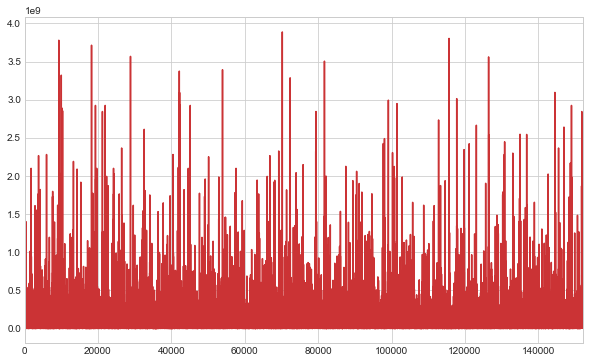

In [11]:
meanSize = df.fileSizeBytes.mean()
medianSize = df.fileSizeBytes.median()


print ("Average file size in MD: %0.2f " % (meanSize / (1024 * 1024)))
print ("Median file size in MD: %0.2f " % (medianSize / (1024 * 1024)))

df.fileSizeBytes.plot(figsize=(10,6))

In [12]:
data['fileSizeInMB'] = df['fileSizeBytes'].apply(lambda x: x / (1024 * 1024))
data.head(10)

,bundleId,trackName,IsUniversal,fileSizeInMB
0,com.aaa.iphone.discounts,AAA Mobile,True,153.721680
1,com.nextgenreality.gunclublite,AAA GUN CLUB lite,False,29.033732
2,com.mcgames.chaosstrike2,Vanguard Online - AAA Shooting Free Online Gam...,True,174.367188
3,com.BulletParty.BunboGames,AAA Bullet Party - Online first person shooter...,True,1182.394531
4,com.fmapp2010.ISearchFree,iSheacher,False,1.434688
5,com.onteca.civilwarlite,AAA American Civil War Cannon Shooter : Defend...,True,107.042969
6,com.appynation.powertoolsfree,Draw with Powertools FX Free,True,56.867188
7,com.1361447304.4691361447304,AAA+ Foundr - Entrepreneur Magazine for a Startup,True,32.477539
8,com.1443792976.11461443792976,AAA+ Swimsuits & Sports Magazine App For Men,True,37.444336
9,com.AnjaneyaApps.AAA1024Free,AAA 1024 Puzzle - cool math board game,True,13.113281


### (6) contentAdvisoryRating

4+               115689
17+               15912
12+               14470
9+                 5972
Not yet rated         4
Name: contentAdvisoryRating, dtype: int64

Normalized distribution
4+               0.760877
17+              0.104652
12+              0.095168
9+               0.039277
Not yet rated    0.000026
Name: contentAdvisoryRating, dtype: float64


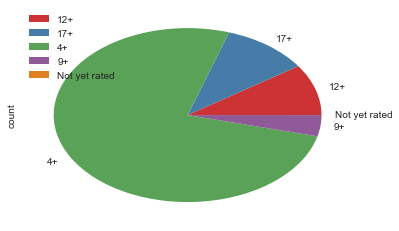

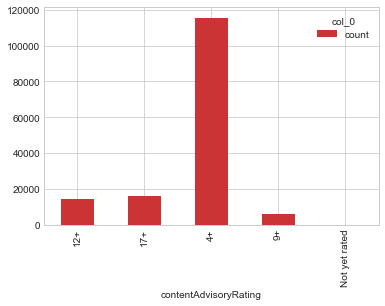

In [13]:
print (df.contentAdvisoryRating.value_counts())
print ()
print ("Normalized distribution")
print (df.contentAdvisoryRating.value_counts(normalize =True))

_ct = pd.crosstab(df.contentAdvisoryRating, "count")
_ct.plot(kind="pie", subplots=True)

_ct.plot(kind="bar")

In [14]:
data['contentAdvisoryRating'] = df['contentAdvisoryRating']

**Summary**: while nearly `75%` is `4+` rated apps other seem to have a meaning full distribution as well;
### (7) genreIds

This feature intutively seem to be highly correlated to `genres` property; So we shall rather look at that in place of this;

### (8) currentVersionReleaseDate
release date of current version; seems an interesting property which doens't need much preprocessing we will keep it as such;

In [15]:
data['currentVersionReleaseDate'] = df.currentVersionReleaseDate

### (9) currency

In [16]:
df.currency.value_counts()

USD    152047
Name: currency, dtype: int64

All values are USD hence we will ignore
### (10) wrapperType

In [17]:
df.wrapperType.value_counts()

software    152047
Name: wrapperType, dtype: int64

all values are software; hence we will ignore
### (11) version

In [18]:
df.version.value_counts().head(20)

1.0      27322
1.1      10589
1.2       6362
2.0       3916
1.3       3715
1.0.1     3329
1.4       2749
1.0.0     2441
1.0.2     2055
1.5       2007
2.1       1865
3.0       1581
1.6       1411
1.0.3     1370
2.2       1220
1.1.0     1127
1.1.1      986
1.7        952
1.0.4      902
4.0        822
Name: version, dtype: int64

**Summary**
 - This seem to be string like property which can have any value;
 We can maybe extract features like major version and subversions

In [19]:
def getMajorVersion(ver):
    return ver.split('.')[0]

def getMajorSubVersion(ver):
    splt = ver.split('.')
    if len(splt) >= 2:
        return ".".join(splt[0:2])
    return splt[0] +".0"

data['version'] = df['version'].apply(lambda x: getMajorVersion(x))
data['subversion'] = df['version'].apply(lambda x: getMajorSubVersion(x))

data[['bundleId', 'version', 'subversion']].head(10)

,bundleId,version,subversion
0,com.aaa.iphone.discounts,3,3.11
1,com.nextgenreality.gunclublite,1,1.7
2,com.mcgames.chaosstrike2,2,2.0
3,com.BulletParty.BunboGames,1,1.0
4,com.fmapp2010.ISearchFree,1,1.3
5,com.onteca.civilwarlite,4,4.1
6,com.appynation.powertoolsfree,2,2.7
7,com.1361447304.4691361447304,7,7.8
8,com.1443792976.11461443792976,7,7.8
9,com.AnjaneyaApps.AAA1024Free,1,1.2


### (12) artistName

In [20]:
print ("artists with max applications")
df.artistName.value_counts().head(20)

artists with max applications


CrowdCompass, Inc.                      789
eChurch Apps                            594
Subsplash Inc                           499
MINDBODY, Incorporated                  441
FMG Suite                               432
DoubleDutch                             384
KitApps, Inc.                           317
SKOOLBAG PTY LTD                        258
AppsVision                              236
EventMobi                               210
Sharefaith                              207
Ketchapp                                200
ChowNow                                 176
Eteg Tecnologia da Informacao Ltda.     172
Tapps Tecnologia da Informação Ltda.    166
Magzter Inc.                            163
Andrew Lakin                            163
AGT Geocentre                           136
AGN Sports                              135
TabTale LTD                             132
Name: artistName, dtype: int64

In [21]:
data['artist'] = df['artistName']

### (13) artistId:
might is highly correlated to artistName and hence will ignore

### (14) genres
This is one of very important property; Let's do some analysis here

In [22]:
import json
genres = {}
for genreString in df.genres.values:
    gs = json.loads(genreString)
    for g in gs:
        if g not in genres:
            genres[g] = 0
        genres[g] = genres[g] + 1

In [23]:
gdf = pd.DataFrame([[k,v] for k,v in genres.items()], columns=['genre', 'count'])
gdf.head(10)

,genre,count
0,Productivity,13092
1,Lifestyle,21424
2,Sports,9946
3,Trivia,2897
4,Finance,8503
5,Medical,6617
6,Racing,3066
7,Music,7662
8,Board,2384
9,News,5702


In [24]:
gs = gdf.sort_values(["count"], axis=0, ascending=False)

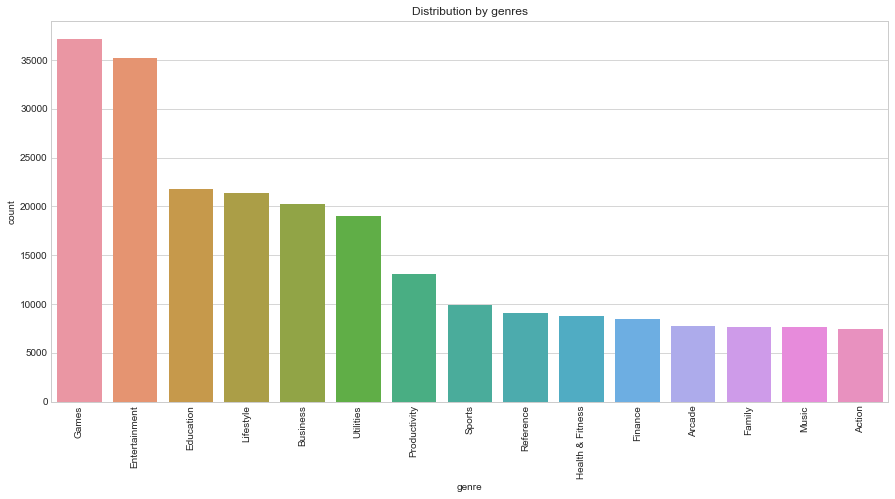

In [25]:
plt.figure(figsize=(15, 7))
fx = sns.barplot(x='genre', y='count', data=gs.head(15))
fx.set_xticklabels(rotation=90, labels=gs['genre'])
plt.title("Distribution by genres")

In [26]:
data['genres'] = df['genres']
data.head(10)

,bundleId,trackName,IsUniversal,fileSizeInMB,contentAdvisoryRating,currentVersionReleaseDate,version,subversion,artist,genres
0,com.aaa.iphone.discounts,AAA Mobile,True,153.721680,4+,2017-12-19T13:23:36Z,3,3.11,American Automobile Association,"[""Lifestyle"", ""Travel""]"
1,com.nextgenreality.gunclublite,AAA GUN CLUB lite,False,29.033732,9+,2009-11-07T02:12:31Z,1,1.7,Gun Club Studios,"[""Entertainment"", ""Games"", ""Simulation"", ""Acti..."
2,com.mcgames.chaosstrike2,Vanguard Online - AAA Shooting Free Online Gam...,True,174.367188,12+,2016-06-13T17:52:01Z,2,2.0,Hasim Mert Corekci,"[""Games"", ""Arcade"", ""Action""]"
3,com.BulletParty.BunboGames,AAA Bullet Party - Online first person shooter...,True,1182.394531,17+,2015-04-22T15:01:15Z,1,1.0,Engin Yildiz,"[""Games"", ""Arcade"", ""Action""]"
4,com.fmapp2010.ISearchFree,iSheacher,False,1.434688,17+,2011-11-23T01:52:45Z,1,1.3,feng min,"[""Photo & Video"", ""Utilities""]"
5,com.onteca.civilwarlite,AAA American Civil War Cannon Shooter : Defend...,True,107.042969,9+,2015-06-29T16:38:41Z,4,4.1,Onteca,"[""Games"", ""Entertainment"", ""Strategy"", ""Simula..."
6,com.appynation.powertoolsfree,Draw with Powertools FX Free,True,56.867188,4+,2016-01-12T23:42:31Z,2,2.7,Onteca,"[""Games"", ""Photo & Video"", ""Trivia"", ""Board""]"
7,com.1361447304.4691361447304,AAA+ Foundr - Entrepreneur Magazine for a Startup,True,32.477539,4+,2017-05-12T22:18:51Z,7,7.8,NHC PUBLISHING PTY. LTD,"[""Business"", ""Magazines & Newspapers""]"
8,com.1443792976.11461443792976,AAA+ Swimsuits & Sports Magazine App For Men,True,37.444336,17+,2017-02-14T21:57:51Z,7,7.8,azacreations,"[""Magazines & Newspapers"", ""Sports""]"
9,com.AnjaneyaApps.AAA1024Free,AAA 1024 Puzzle - cool math board game,True,13.113281,4+,2014-05-28T07:00:00Z,1,1.2,Bharat Bhushan,"[""Games"", ""Puzzle"", ""Entertainment"", ""Family""]"


### (15) Price
One of most important field

In [27]:
percentageFree = df[df.price == 0].shape[0] / df.shape[0] * 100

print ("%% Free: %0.3f %%" % percentageFree)

% Free: 89.683 %


In [28]:
data['price'] = df['price']

In [29]:
data.head(3)

,bundleId,trackName,IsUniversal,fileSizeInMB,contentAdvisoryRating,currentVersionReleaseDate,version,subversion,artist,genres,price
0,com.aaa.iphone.discounts,AAA Mobile,True,153.721680,4+,2017-12-19T13:23:36Z,3,3.11,American Automobile Association,"[""Lifestyle"", ""Travel""]",0.0
1,com.nextgenreality.gunclublite,AAA GUN CLUB lite,False,29.033732,9+,2009-11-07T02:12:31Z,1,1.7,Gun Club Studios,"[""Entertainment"", ""Games"", ""Simulation"", ""Acti...",0.0
2,com.mcgames.chaosstrike2,Vanguard Online - AAA Shooting Free Online Gam...,True,174.367188,12+,2016-06-13T17:52:01Z,2,2.0,Hasim Mert Corekci,"[""Games"", ""Arcade"", ""Action""]",0.0


### (16) Description
This is a plain text field, will just copy it to new dataframe and use as text features later

In [30]:
data['description'] = df.description

### (17) isVppDeviceBasedLicensingEnabled
I don't totally know what this feature means (TODO);
99.2% sample have true value rest have false, but stills storing this to actual df

In [31]:
df.isVppDeviceBasedLicensingEnabled.value_counts(normalize=True) * 100

True     99.23379
False     0.76621
Name: isVppDeviceBasedLicensingEnabled, dtype: float64

In [32]:
data['isVppDeviceBasedLicensingEnabled'] = df.isVppDeviceBasedLicensingEnabled

### (17) primaryGenreName
This is an interesting feature

In [33]:
df.primaryGenreName.value_counts(normalize=True) * 100

Games                     21.761692
Business                   9.347110
Education                  9.330667
Entertainment              6.327649
Lifestyle                  6.323045
Utilities                  5.839642
Finance                    4.533467
Health & Fitness           3.639664
Productivity               3.324630
Medical                    3.221372
Sports                     3.112853
Music                      3.049715
Travel                     3.023407
Photo & Video              2.667596
Reference                  2.509093
News                       2.199320
Social Networking          1.954001
Shopping                   1.918486
Food & Drink               1.836932
Book                       1.792867
Navigation                 1.232514
Stickers                   0.545226
Weather                    0.436707
Magazines & Newspapers     0.072346
Name: primaryGenreName, dtype: float64

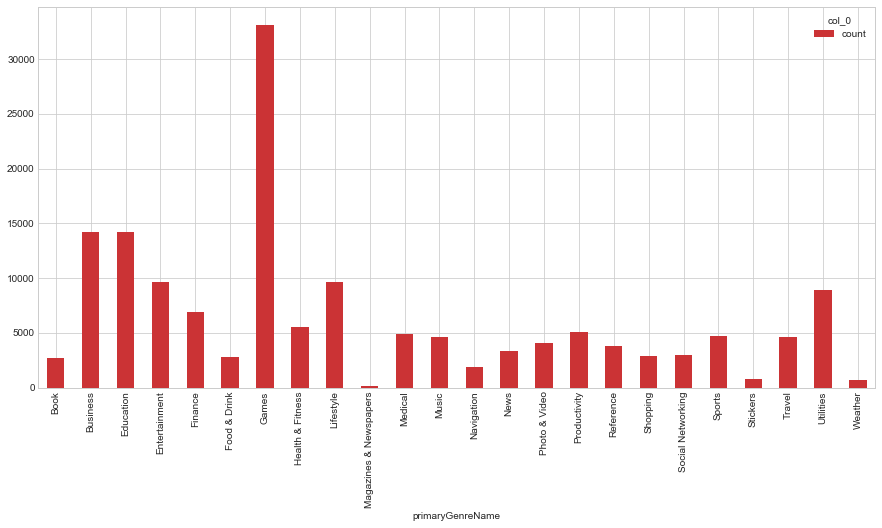

In [34]:
_ct = pd.crosstab(df.primaryGenreName, "count")
_ct.plot(kind='bar', figsize=(15, 7))

In [35]:
data['primaryGenreName'] = df.primaryGenreName

### (17) releaseDate
released date of app; This could be related to how old the app is

In [36]:
# data['releaseDate'] = df.releaseDate
from datetime import datetime
def getAgeInDays(datestring):
    return (datetime.now() - datetime.strptime(datestring, "%Y-%m-%dT%H:%M:%SZ")).days

data['releaseDate'] = df.releaseDate
data['ageInDays'] = df.releaseDate.apply(lambda x: getAgeInDays(x))

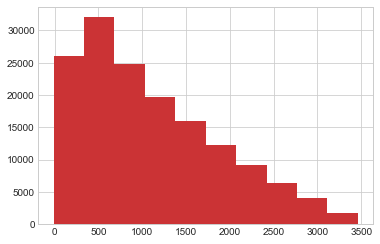

In [37]:
data['ageInDays'].hist()

### (18) minimumOsVersion
We will just keep the main version no for simplicity

In [38]:
def getMajorOSVersion(osver):
    return osver.split(".")[0]
data['minimumOsVersion'] = df.minimumOsVersion.apply(lambda x: getMajorOSVersion(x))

In [39]:
# % distribution
data['minimumOsVersion'].value_counts(normalize=True) * 100

8     31.439621
7     18.854696
6     17.125626
9     16.012154
5      5.462785
10     4.393378
4      4.349313
3      1.744855
11     0.417634
2      0.199938
Name: minimumOsVersion, dtype: float64

### (19) formattedPrice
Since we have price we will ignore this

### (20) primaryGenreId
Since we have string of primary Genre we will ignore this

### (21, 22) averageUserRating & avgUserRatingCV
This is another most important feature

In [40]:
# Actual
df.averageUserRating.value_counts(normalize=True) * 100

null    62.251804
4.5     12.058114
4.0      8.175761
3.5      5.300992
3.0      3.787645
5.0      3.615987
2.5      2.506462
2.0      1.441002
1.5      0.638618
1.0      0.223615
Name: averageUserRating, dtype: float64

In [41]:
# current version
df.avgUserRatingCV.value_counts(normalize=True) * 100

null    58.281321
5.0     10.167251
4.5      9.463521
4.0      6.521668
3.5      4.003367
3.0      3.758048
1.0      3.016173
2.5      2.093432
2.0      1.812597
1.5      0.882622
Name: avgUserRatingCV, dtype: float64

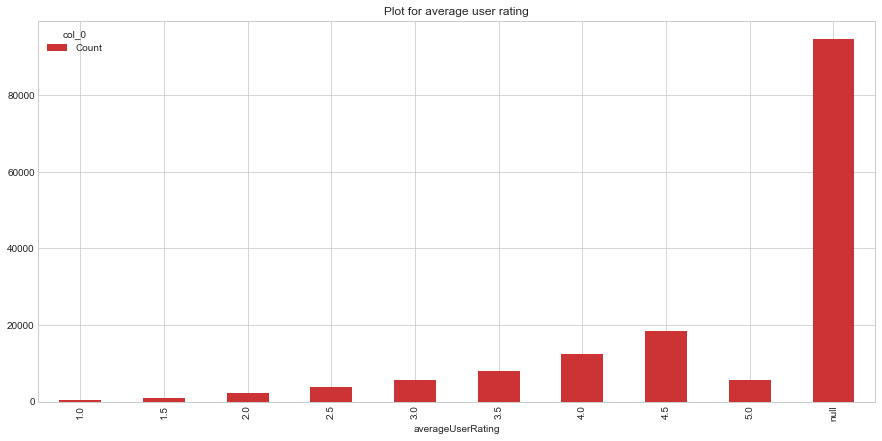

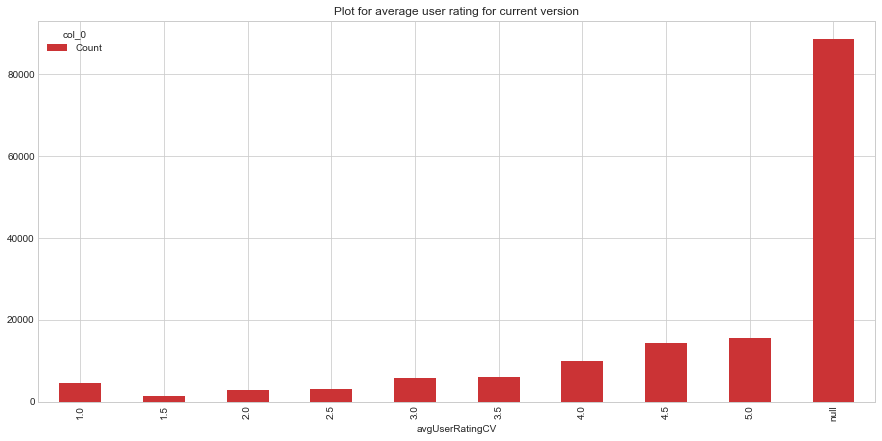

In [42]:
_ct = pd.crosstab(df.averageUserRating, "Count")
_ct.plot(kind='bar', figsize=(15, 7))
plt.title("Plot for average user rating")

_ct = pd.crosstab(df.avgUserRatingCV, "Count")
_ct.plot(kind='bar', figsize=(15, 7))
plt.title("Plot for average user rating for current version")

In [43]:
data['averageUserRating'] = df.averageUserRating
data['avgUserRatingCV'] = df.avgUserRatingCV

**Sumamry**: maximum apps have no user rating at all;
### (23, 24) userRatingCount & userRatingCountCV

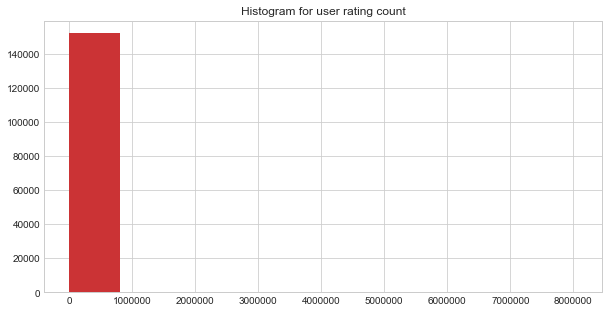

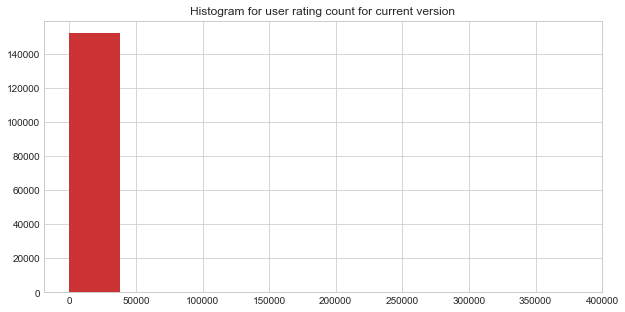

In [44]:
data['userRatingCount'] = df.userRatingCount.replace('null', 0)
data.userRatingCount = data.userRatingCount.apply(lambda x: int(x))
data.userRatingCount.hist(figsize=(10, 5))
plt.title("Histogram for user rating count")

plt.figure()
data['userRatingCountCV'] = df.userRatingCountCV.replace('null', 0)
data.userRatingCountCV = data.userRatingCountCV.apply(lambda x: int(x))
data.userRatingCountCV.hist(figsize=(10, 5))
plt.title("Histogram for user rating count for current version")

### (25) sellerUrl
 - Not all of the sellers have url, so one interesting property would be to check if website exist on the first place

In [45]:
data['hasUrl'] = df.sellerUrl.apply(lambda x: x != 'null')
data['hasUrl'].head(10)

0    False
1     True
2    False
3    False
4     True
5    False
6    False
7    False
8     True
9    False
Name: hasUrl, dtype: bool

In [46]:
def getDomain(url):
    if url == 'null':
        return 'null'
    
    _splt = url.split('/')
    if len(_splt) >= 3:
        return _splt[2]
    return 'null'

data['sellerUrl'] = df.sellerUrl
data['sellerUrlDomain'] = df.sellerUrl.apply(lambda x: getDomain(x))

In [47]:
data.head(10)

,bundleId,trackName,IsUniversal,fileSizeInMB,contentAdvisoryRating,currentVersionReleaseDate,version,subversion,artist,genres,...,releaseDate,ageInDays,minimumOsVersion,averageUserRating,avgUserRatingCV,userRatingCount,userRatingCountCV,hasUrl,sellerUrl,sellerUrlDomain
0,com.aaa.iphone.discounts,AAA Mobile,True,153.721680,4+,2017-12-19T13:23:36Z,3,3.11,American Automobile Association,"[""Lifestyle"", ""Travel""]",...,2009-04-21T04:39:36Z,3177,10,3.0,3.0,24767,34,False,null,null
1,com.nextgenreality.gunclublite,AAA GUN CLUB lite,False,29.033732,9+,2009-11-07T02:12:31Z,1,1.7,Gun Club Studios,"[""Entertainment"", ""Games"", ""Simulation"", ""Acti...",...,2009-04-28T07:00:00Z,3170,2,3.5,3.5,30957,20294,True,http://www.thebinarymill.com/gunclub3/,www.thebinarymill.com
2,com.mcgames.chaosstrike2,Vanguard Online - AAA Shooting Free Online Gam...,True,174.367188,12+,2016-06-13T17:52:01Z,2,2.0,Hasim Mert Corekci,"[""Games"", ""Arcade"", ""Action""]",...,2016-01-30T00:15:05Z,702,7,4.0,4.0,403,259,False,null,null
3,com.BulletParty.BunboGames,AAA Bullet Party - Online first person shooter...,True,1182.394531,17+,2015-04-22T15:01:15Z,1,1.0,Engin Yildiz,"[""Games"", ""Arcade"", ""Action""]",...,2014-11-06T01:21:25Z,1152,6,3.5,3.5,165,146,False,null,null
4,com.fmapp2010.ISearchFree,iSheacher,False,1.434688,17+,2011-11-23T01:52:45Z,1,1.3,feng min,"[""Photo & Video"", ""Utilities""]",...,2010-05-19T07:00:00Z,2784,3,2.5,2.0,322,71,True,http://clotapp.blog.com/2010/04/19/all-images-...,clotapp.blog.com
5,com.onteca.civilwarlite,AAA American Civil War Cannon Shooter : Defend...,True,107.042969,9+,2015-06-29T16:38:41Z,4,4.1,Onteca,"[""Games"", ""Entertainment"", ""Strategy"", ""Simula...",...,2012-11-16T20:26:43Z,1871,6,3.0,3.5,199,50,False,null,null
6,com.appynation.powertoolsfree,Draw with Powertools FX Free,True,56.867188,4+,2016-01-12T23:42:31Z,2,2.7,Onteca,"[""Games"", ""Photo & Video"", ""Trivia"", ""Board""]",...,2012-08-02T19:17:30Z,1977,7,4.0,2.5,64,4,False,null,null
7,com.1361447304.4691361447304,AAA+ Foundr - Entrepreneur Magazine for a Startup,True,32.477539,4+,2017-05-12T22:18:51Z,7,7.8,NHC PUBLISHING PTY. LTD,"[""Business"", ""Magazines & Newspapers""]",...,2013-03-05T00:19:42Z,1763,8,5.0,5.0,325,5,False,null,null
8,com.1443792976.11461443792976,AAA+ Swimsuits & Sports Magazine App For Men,True,37.444336,17+,2017-02-14T21:57:51Z,7,7.8,azacreations,"[""Magazines & Newspapers"", ""Sports""]",...,2015-10-13T20:10:31Z,810,8,4.0,3.5,86,17,True,http://www.swimsuitsandsports.com/,www.swimsuitsandsports.com
9,com.AnjaneyaApps.AAA1024Free,AAA 1024 Puzzle - cool math board game,True,13.113281,4+,2014-05-28T07:00:00Z,1,1.2,Bharat Bhushan,"[""Games"", ""Puzzle"", ""Entertainment"", ""Family""]",...,2014-05-28T07:00:00Z,1314,6,4.5,4.5,7,7,False,null,null


### (26) releaseNotes

In [48]:
data['releaseNotes'] = df.releaseNotes

## Write new data frame to disk

In [49]:
# data.to_csv("../dataset/processed.data.csv")

### Let's have a look at summary so far for paid apps

In [50]:
paidApps = df[df.price > 0]
paidApps.shape

(15687, 30)

**Summary**: around 15.5K paid apps have been mined; Let's look at their `contentAdvisoryRating` and `Genres`

In [51]:
def plotSummary(_df, figsize=(15, 7)):
    print (_df.contentAdvisoryRating.value_counts())
    print ()
    print ("Normalized distribution")
    print (_df.contentAdvisoryRating.value_counts(normalize =True))

    _ct = pd.crosstab(_df.contentAdvisoryRating, "count")
    _ct.plot(kind="pie", subplots=True)
    _ct.plot(kind="bar")
    plt.title("Distribution by content advisory rating")    
    
    # Genres
    _genres = {}
    for genreString in _df.genres.values:
        gs = json.loads(genreString)
        for g in gs:
            if g not in _genres:
                _genres[g] = 0
            _genres[g] = _genres[g] + 1
    
    _gdf = pd.DataFrame([[k,v] for k,v in _genres.items()], columns=['genre', 'count'])
    _gs = _gdf.sort_values(["count"], axis=0, ascending=False)
    
    plt.figure(figsize=figsize)
    fx = sns.barplot(x='genre', y='count', data=_gs.head(30))
    fx.set_xticklabels(rotation=90, labels=_gs['genre'])
    plt.title("Distribution by genres")
    
    _ct = pd.crosstab(_df.primaryGenreName, "count")
    _ct.plot(kind='bar', figsize=figsize)
    plt.title("Distribution by primary genres")


4+     12458
12+     1366
17+     1133
9+       730
Name: contentAdvisoryRating, dtype: int64

Normalized distribution
4+     0.794161
12+    0.087078
17+    0.072225
9+     0.046535
Name: contentAdvisoryRating, dtype: float64


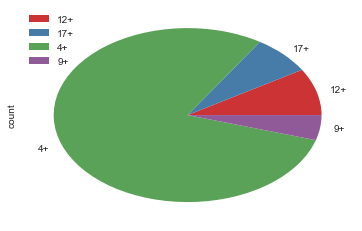

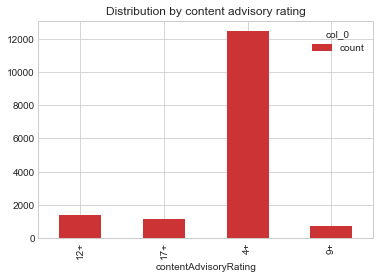

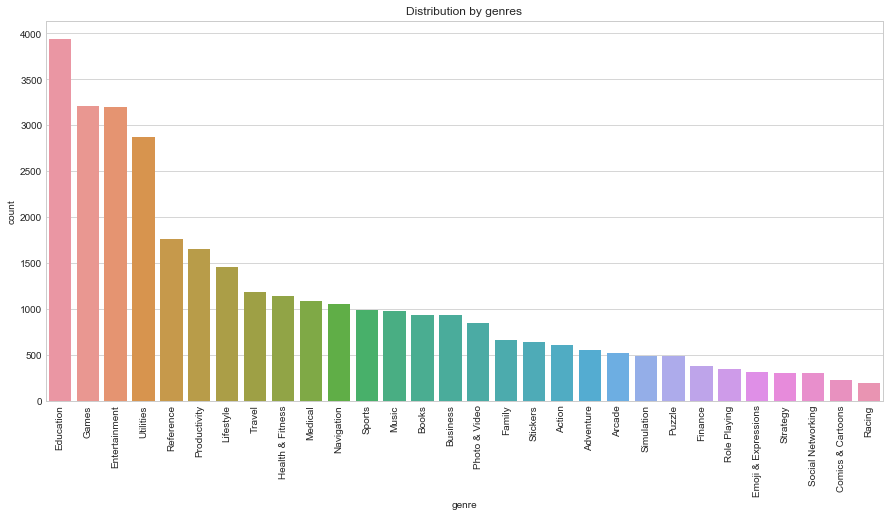

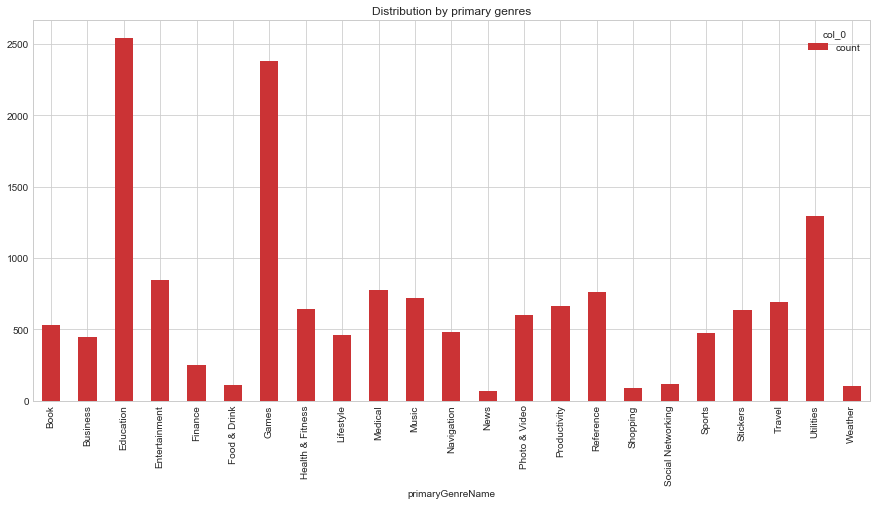

In [52]:
plotSummary(paidApps)

**Summary**:
 - Paid apps are more educational as compared to Games or Entertainment
 - Content Advisory Rating seem to be similar to free apps